### Time Series Analysis
### Apple Stock Price

### Link for the Dataset
https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/TechStocks.csv

### Description of the dataset </br>
https://vincentarelbundock.github.io/Rdatasets/doc/Stat2Data/TechStocks.html

### Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from pandas import Series
import matplotlib.pyplot as plt
import itertools
import statsmodels
from scipy.stats import kurtosis
from scipy.stats import skew
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from arch import arch_model
import time
import warnings
warnings.filterwarnings("ignore")

### Read the data

In [2]:
data_raw=pd.read_csv("/home/rohan/Downloads/TechStocks.csv")

In [3]:
data_raw.head(5)

,Unnamed: 0,Date,AAPL,GOOG,MSFT,t
0,1,12/1/2015,117.34,767.04,55.22,1
1,2,12/2/2015,116.28,762.38,55.21,2
2,3,12/3/2015,115.20,752.54,54.20,3
3,4,12/4/2015,119.03,766.81,55.91,4
4,5,12/7/2015,118.28,763.25,55.81,5


In [4]:
data_raw.tail(5)

,Unnamed: 0,Date,AAPL,GOOG,MSFT,t
499,500,11/27/2017,174.09,1054.21,83.87,500
500,501,11/28/2017,173.07,1047.41,84.88,501
501,502,11/29/2017,169.48,1021.66,83.34,502
502,503,11/30/2017,171.85,1021.41,84.17,503
503,504,12/1/2017,171.05,1010.17,84.26,504


In [5]:
data_raw.shape

(504, 6)

### Working with Apple Stock Price Data

In [6]:
data=data_raw[["Date","AAPL"]]

In [7]:
data.head(10)

,Date,AAPL
0,12/1/2015,117.34
1,12/2/2015,116.28
2,12/3/2015,115.20
3,12/4/2015,119.03
4,12/7/2015,118.28
5,12/8/2015,118.23
6,12/9/2015,115.62
7,12/10/2015,116.17
8,12/11/2015,113.18
9,12/14/2015,112.48


In [8]:
data['Date'] = pd.to_datetime(data['Date'],infer_datetime_format=True) #convert from string to datetime
data = data.set_index(['Date'])
data.head(5)

,AAPL
Date,
2015-12-01,117.34
2015-12-02,116.28
2015-12-03,115.20
2015-12-04,119.03
2015-12-07,118.28


### Summary Statistics

In [9]:
data["AAPL"].describe()

count    504.000000
mean     125.008813
std       24.232601
min       90.340000
25%      105.702500
50%      116.225000
75%      146.592500
max      175.880000
Name: AAPL, dtype: float64

### Skewness

In [10]:
skew(data["AAPL"])

0.38680474358605693

### Kurtosis

In [11]:
kurtosis(list(data["AAPL"]))

-1.257047946844429

In [12]:
#plt.hist(data["AAPL"], bins=np.arange(data["AAPL"].min(), data["AAPL"].max()+1))

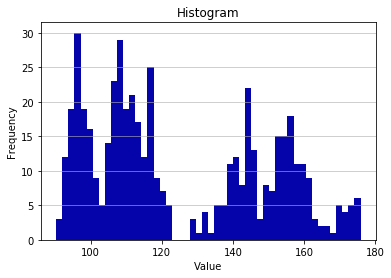

In [13]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(data["AAPL"], bins=50, color='#0504aa',
                            alpha=1, rwidth=3)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
maxfreq = n.max()

### Plotting the data

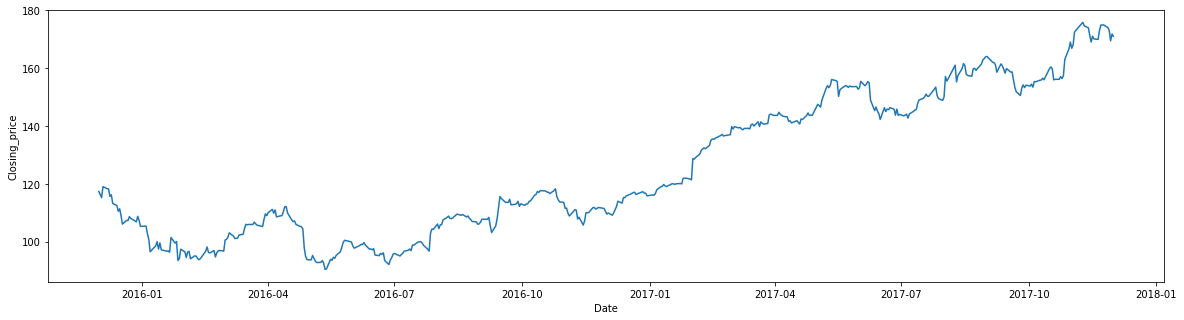

In [14]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(data)
plt.xlabel('Date')
plt.ylabel('Closing_price')
plt.show()


In [15]:
data[['AAPL']].idxmin() 

AAPL   2016-05-12
dtype: datetime64[ns]

In [16]:
data[['AAPL']].idxmax() 

AAPL   2017-11-09
dtype: datetime64[ns]

### Test for Stationarity

### Augmented Dickey-Fuller (ADF) test

In [17]:
X = data["AAPL"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.433639
p-value: 0.982710
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


##### Null Hypothesis : Data is non-stationary<br>

So we fail to reject the null hypothesis at 1%,5%,10% level of significance as the value of the test statistic is greater than the critical values.<br>
##### Conclusion: The data is non-stationary

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [18]:
result_kpss=statsmodels.tsa.stattools.kpss(X)
print('KPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic: 2.504662
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


##### Null Hypothesis : Data is stationary<br>

So we reject the null hypothesis at 2.5%,5%,10% level of significance as the value of the test statistic is less than the critical values.<br>
##### Conclusion: The data is non-stationary

### Phillips Perron test for stationarity

In [19]:
pp=PhillipsPerron(data["AAPL"])
pp.summary

<bound method UnitRootTest.summary of <class 'arch.unitroot.unitroot.PhillipsPerron'>
"""
     Phillips-Perron Test (Z-tau)    
Test Statistic                  0.225
P-value                         0.974
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
""">

##### Null Hypothesis : Data is non-stationary<br>

So we fail to reject the null hypothesis at 1%,5%,10% level of significance as the p-value is much greater than 0.05/0.1<br>
##### Conclusion: The data is non-stationary

### First Order log Difference

In [20]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)


In [21]:
import math

In [22]:
data["log_AAPL"]=np.log(data["AAPL"])    

In [23]:
data.head(5)

,AAPL,log_AAPL
Date,,
2015-12-01,117.34,4.765076
2015-12-02,116.28,4.756001
2015-12-03,115.20,4.746670
2015-12-04,119.03,4.779376
2015-12-07,118.28,4.773055


#### Log difference series

In [24]:
log_diff_series=difference(data["log_AAPL"],1)

### Summary Statistics of log differenced series

In [25]:
log_diff_series.describe()

count    503.000000
mean       0.000749
std        0.013363
min       -0.067965
25%       -0.005260
50%        0.000666
75%        0.007343
max        0.062940
dtype: float64

In [26]:
skew(log_diff_series) ### Skewness

-0.09773336601341133

In [27]:
kurtosis(log_diff_series) ### Kurtosis

4.427769297411142

### Plot the log differenced series

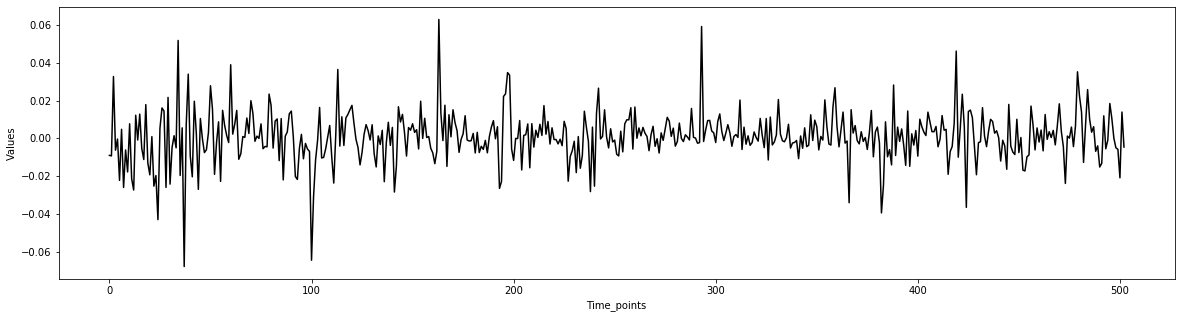

In [28]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(log_diff_series,"black")
plt.xlabel('Time_points')
plt.ylabel('Values')
plt.show()


Text(0.5, 1.0, 'Log Differenced Data')

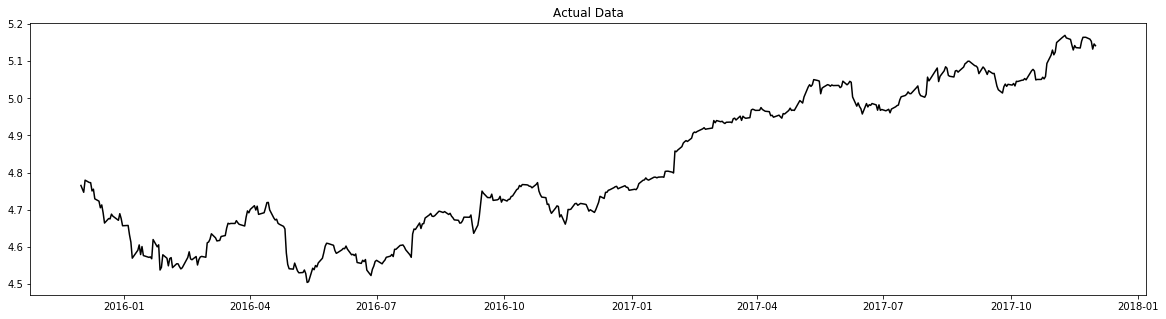

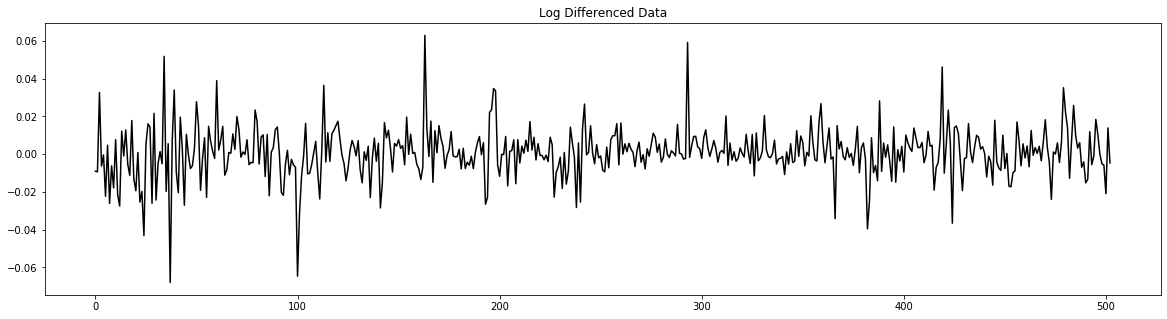

In [29]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(data["log_AAPL"],"black")
ax.set_title('Actual Data')
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(log_diff_series,"black")
ax.set_title('Log Differenced Data')


### ADF test for log differenced series

In [30]:
result = adfuller(log_diff_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -21.277876
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


##### Null Hypothesis : Data is non-stationary<br>

So we reject the null hypothesis at 1%,5%,10% level of significance as the value of the test statistic is smaller than the critical values.<br>
##### Conclusion: The data is stationary

### KPSS test for log differenced series

In [31]:
result_kpss=statsmodels.tsa.stattools.kpss(log_diff_series)
print('KPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.260838
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


##### Null Hypothesis : Data is stationary<br>

So we fail to reject the null hypothesis at 1%,2.5%,5% level of significance as the value of the test statistic is less than the critical values.<br>
##### Conclusion: The data is stationary

### Phillips Peron Test

In [32]:
pp=PhillipsPerron(log_diff_series)
pp.summary

<bound method UnitRootTest.summary of <class 'arch.unitroot.unitroot.PhillipsPerron'>
"""
     Phillips-Perron Test (Z-tau)    
Test Statistic                -21.442
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
""">

##### Null Hypothesis : Data is non-stationary<br>

So we reject the null hypothesis at 1%,5%,10% level of significance as the p-value is less than 0.01.<br>
##### Conclusion: The data is stationary

### Train-test Split

In [33]:
#Train Data
train_series=log_diff_series[:495]
#Test Data
test_series=log_diff_series[495:]

### ACF plot for the differenced series

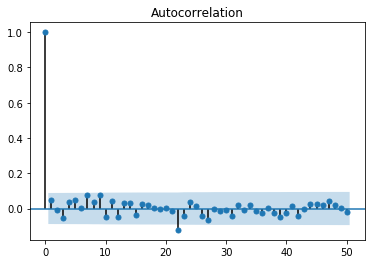

In [34]:
plot_acf(train_series,lags=50)
pyplot.show()

### PACF plot for the differenced series

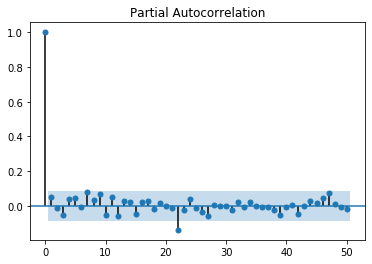

In [35]:
plot_pacf(train_series,lags=50)
pyplot.show()

### Determining Order of ARIMA model

In [36]:
#AR_order=MA_order
p=q=range(1,6)
d=range(0,2)
pdq = list(itertools.product(p, d, q))

In [37]:
models_aic_values=[]
for i in pdq:
    model_temp = ARIMA(train_series, order=i)
    try:
        model_temp_fit = model_temp.fit(disp=0)
        models_aic_values.append([model_temp_fit.aic,i])
    except ValueError:
        #models_aic_values.append(["not computable",i])
        pass

In [38]:
min(models_aic_values)

[-2860.1568091256822, (1, 0, 1)]

In [39]:
# models_aic_values=[]
# for i in pdq:
#     model_temp = ARIMA(train_series, order=i)
#     try:
#         model_temp_fit = model_temp.fit(disp=0)
#     except ValueError:
#         #models_aic_values.append(["not computable",i])
#         pass
#     else:
#         models_aic_values.append([model_temp_fit.aic,i])
    

### Fitting ARIMA model

In [40]:
start=time.time()
model = ARIMA(train_series, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
end=time.time()
print(end-start)

                              ARMA Model Results                              
Dep. Variable:                   None   No. Observations:                  495
Model:                     ARMA(1, 1)   Log Likelihood                1434.078
Method:                       css-mle   S.D. of innovations              0.013
Date:                Tue, 19 Nov 2019   AIC                          -2860.157
Time:                        12:11:03   BIC                          -2843.339
Sample:                             0   HQIC                         -2853.555
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.186      0.236      -0.000       0.002
ar.L1.None    -0.0162      0.475     -0.034      0.973      -0.948       0.916
ma.L1.None     0.0676      0.473      0.143      0.8

In [41]:
# plt.figure(figsize=(16,8))
# plt.plot(train_series, label='original')
# plt.plot(model_fit.fittedvalues, color='red', label='predictions')
# plt.legend(loc='best')
# plt.show()

In [42]:
# fig, ax = plt.subplots(figsize=(20,5))
# plt.plot(train_series,"black")
# ax.set_title('Train Data')
# fig, ax = plt.subplots(figsize=(20,5))
# plt.plot(model_fit.fittedvalues,"black")
# ax.set_title('Fitted Values')


In [43]:
forecast = model_fit.predict(start = 495, end= 502, dynamic= True)

In [44]:
list(forecast)

[0.0006825896055256474,
 0.0007487000434853137,
 0.0007476276473449418,
 0.0007476450429864983,
 0.0007476447608068691,
 0.0007476447653841848,
 0.0007476447653099349,
 0.0007476447653111393]

### ARIMA prediction for the actual data

In [45]:
def return_test_values(series):
    forecast_values =[]
    k=list(data["AAPL"])[494]
    ratios=list(np.exp(series))
    first_forecast=k*ratios[0]
    forecast_values.append(first_forecast)
    for i in range(1,len(series)):
        forecast_values.append(ratios[i]*forecast_values[-1])
    return forecast_values    

In [46]:
arima_main_forecast=return_test_values(forecast)
arima_main_forecast

[170.2661822692738,
 170.39370830075845,
 170.52114698042192,
 170.64868394093352,
 170.77631624128563,
 170.90404400172108,
 171.03186729284235,
 171.15978618611211]

In [47]:
actual_test_values=list(data["AAPL"])[495:]
actual_test_values

[169.98, 173.14, 174.96, 174.97, 174.09, 173.07, 169.48, 171.85, 171.05]

### Plot for the log differenced series

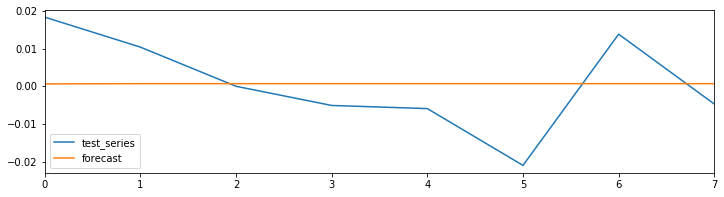

In [48]:
test_dataframe=pd.DataFrame(list(zip(test_series,forecast)),
             columns=['test_series','forecast'])

test_dataframe[['test_series', 'forecast']].plot(figsize=(12, 3))

In [50]:
#len(test_series)
len(forecast)

8

In [51]:
# fig, ax = plt.subplots(figsize=(20,5))
# plt.plot(forecast,"black")
# ax.set_title('Predicted')

In [52]:
len(model_fit.fittedvalues)

495

In [53]:
list(train_series)[1]-model_fit.fittedvalues[1]

-0.009575650437760406

### Residuals

In [54]:
residuals=list(model_fit.resid)

In [55]:
residuals_squared = [i*i for i in residuals]

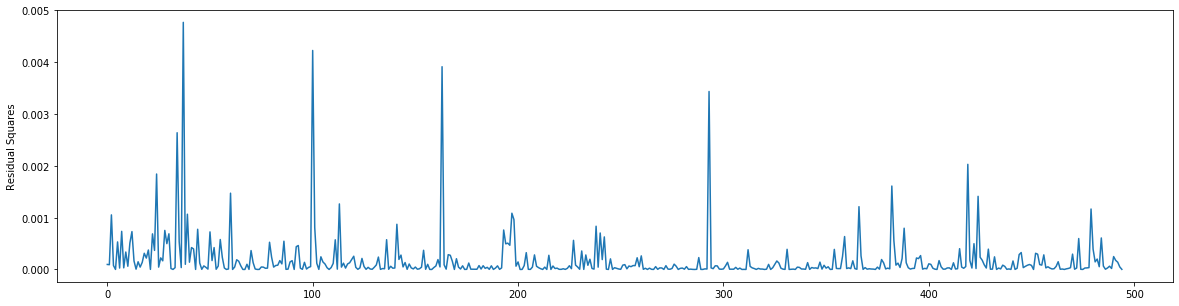

In [56]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(residuals_squared)
plt.ylabel('Residual Squares')
plt.show()


### Ljung Box test

In [57]:
nlags = 20
results_resi = sm.stats.diagnostic.acorr_ljungbox(residuals, nlags)

In [58]:
results_resi[1]

array([0.99980822, 0.99360975, 0.64850077, 0.68484254, 0.64189591,
       0.75861312, 0.52734325, 0.59381171, 0.40034701, 0.35646794,
       0.34193619, 0.32897813, 0.36612717, 0.41084246, 0.42916873,
       0.47820087, 0.53574381, 0.60413303, 0.66831614, 0.72640761])

### Check the plot (p-values)

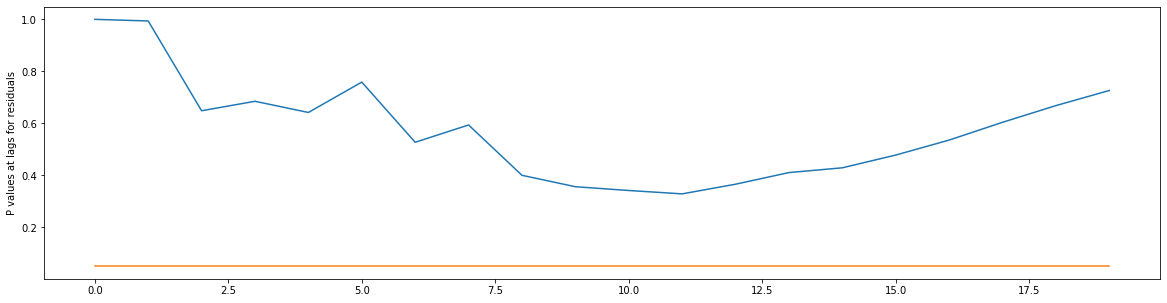

In [59]:
constant=[0.05 for i in range(20)]
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(results_resi[1])
plt.plot(constant)
plt.ylabel('P values at lags for residuals')
plt.show()

### For Residual Square

In [60]:
results_resi2 = sm.stats.diagnostic.acorr_ljungbox(residuals_squared, nlags)

In [61]:
results_resi2[1]

array([0.47070376, 0.25845389, 0.05181736, 0.06988602, 0.02733554,
       0.04956002, 0.03604435, 0.05918358, 0.0909755 , 0.09555242,
       0.12739781, 0.15817342, 0.0223856 , 0.03205328, 0.04379492,
       0.06171598, 0.0843638 , 0.11152254, 0.14425055, 0.18204604])

### Check the plot (p-values)

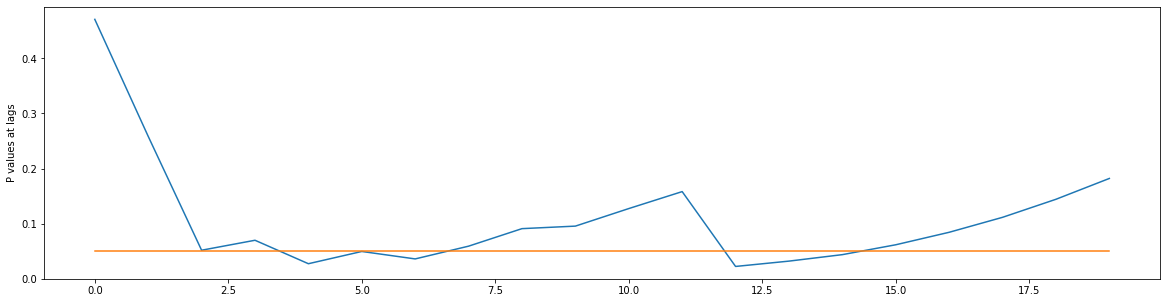

In [62]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(results_resi2[1])
plt.plot(constant)
plt.ylabel('P values at lags')
plt.show()

In [63]:
# model2 = auto_arima(residuals_squared, start_p=1, start_q=1, start_P=1, start_Q=1,
#                   max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
#                   stepwise=True, suppress_warnings=True, D=10, max_D=10,
#                   error_action='ignore')
# model2.fit(residuals_squared)

### Stationarity test for the residual squares

#### ADF test

In [64]:
result = adfuller(residuals_squared)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.964750
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


#### KPSS test

In [65]:
result_kpss=statsmodels.tsa.stattools.kpss(residuals_squared)
print('KPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.676540
p-value: 0.015678
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


#### PP test

In [66]:
pp=PhillipsPerron(residuals_squared)
pp.summary

<bound method UnitRootTest.summary of <class 'arch.unitroot.unitroot.PhillipsPerron'>
"""
     Phillips-Perron Test (Z-tau)    
Test Statistic                -22.333
P-value                         0.000
Lags                               18
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
""">

### ARIMA model on the residual squares

#### Determining the order of the model

In [67]:
#AR_order=MA_order
p=q=range(1,6)
d=range(0,3)
pdq = list(itertools.product(p, d, q))

In [68]:
models_2_aic_values=[]

for i in pdq:
    model_temp = ARIMA(residuals_squared, order=i)
    try:
        model_temp_fit = model_temp.fit(disp=0)
        models_2_aic_values.append([model_temp_fit.aic,i])
    except ValueError:
        #models_aic_values.append(["not computable",i])
        pass

In [69]:
min(models_2_aic_values)

[-6216.891287335508, (3, 0, 2)]

In [70]:
model_2 = ARIMA(residuals_squared, order=(3,0,2))
model_2_fit = model_2.fit(disp=0)
print(model_2_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  495
Model:                     ARMA(3, 2)   Log Likelihood                3115.446
Method:                       css-mle   S.D. of innovations              0.000
Date:                Tue, 19 Nov 2019   AIC                          -6216.891
Time:                        12:12:51   BIC                          -6187.459
Sample:                             0   HQIC                         -6205.337
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   2.96e-05      6.037      0.000       0.000       0.000
ar.L1.y       -0.1846      0.171     -1.078      0.281      -0.520       0.151
ar.L2.y        0.7286      0.145      5.040      0.0

In [72]:
garch32 = arch_model(train_series, p=3, q=2)
garch32_fit = garch32.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: -1445.980910911404
Iteration:      2,   Func. Count:     25,   Neg. LLF: -1446.1245363802966
Iteration:      3,   Func. Count:     44,   Neg. LLF: -1444.624101256763
Iteration:      4,   Func. Count:     60,   Neg. LLF: -1446.1133262768708
Iteration:      5,   Func. Count:     76,   Neg. LLF: -1446.1142952295972
Iteration:      6,   Func. Count:     95,   Neg. LLF: -1445.954969916524
Iteration:      7,   Func. Count:    111,   Neg. LLF: -1446.1102186506748
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1446.1102354621098
            Iterations: 11
            Function evaluations: 111
            Gradient evaluations: 7


/home/rohan/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




In [73]:
garch32_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                1446.11
Distribution:                  Normal   AIC:                          -2878.22
Method:            Maximum Likelihood   BIC:                          -2848.79
                                        No. Observations:                  495
Date:                Tue, Nov 19 2019   Df Residuals:                      488
Time:                        12:13:05   Df Model:                            7
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0626e-03  5.328e-05     19.942  1.763e-88 [9.582e-04,1.167e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.5767e-06  4.768e-11  7.502e+04      0.000  [3.577e-06,3.577e-06]
alpha[1]   3.3342e-03  2.585e-02      0.129      0.897 [-4.733e-02,5.399e-02]
alpha[2]   3.3342e-03  8.867e-02  3.760e-02      0.970      [ -0.170,  0.177]
alpha[3]   3.3342e-03  6.747e-02  4.942e-02      0.961      [ -0.129,  0.136]
beta[1]        0.4850      0.500      0.969      0.333      [ -0.496,  1.466]
beta[2]        0.4850      0.557      0.871      0.384      [ -0.607,  1.577]
=============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

In [74]:
garch_forecast = garch32_fit.forecast(start = 0,horizon = 8)

In [75]:
print(garch_forecast)

In [76]:
#garch_forecast.residual_variance

In [77]:
expected_error_sqr = list(garch_forecast.residual_variance.loc[494])

In [78]:
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 8)

In [83]:
s

array([ 0.54597654,  1.49998551,  0.62338861,  2.31108927,  0.14147984,
       -1.59433656,  2.60492082,  0.46438868])

In [91]:
mu, sigma = 0, 1 # mean and standard deviation
s2 = np.random.normal(mu, sigma, 8)

In [92]:
s2

array([-0.10586245,  1.34618788, -0.72688755, -1.49209267,  0.2210376 ,
       -0.79079437, -0.46300124,  1.09938986])

In [79]:
expected_error = [np.sqrt(i) for i in expected_error_sqr]

In [84]:
error_part=expected_error*s

In [85]:
garch_forecast = list(map(np.add,forecast,error_part))

In [88]:
garch_forecast

[0.007741189361302043,
 0.020118556535398627,
 0.008795015389490044,
 0.030608550802300828,
 0.0025761642701368132,
 -0.019869698285076523,
 0.034447437724744075,
 0.00675832001818496]

### Forecast values using garch model

In [86]:
garch_main_forecast=return_test_values(garch_forecast)
garch_main_forecast

[171.47227475624888,
 174.9569855482929,
 176.50252147225726,
 181.98853908534107,
 182.4579758708212,
 178.86837121993477,
 185.1372823695378,
 186.3927369745237]

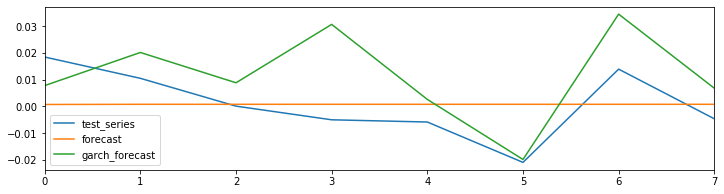

In [89]:
test_dataframe=pd.DataFrame(list(zip(test_series,forecast,garch_forecast)),
             columns=['test_series','forecast','garch_forecast'])

test_dataframe[['test_series', 'forecast','garch_forecast']].plot(figsize=(12, 3))

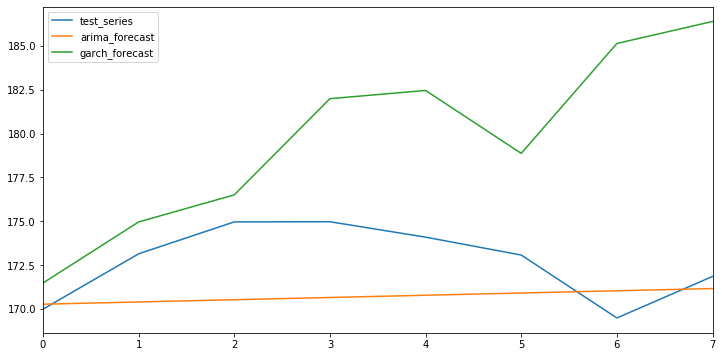

In [90]:
test_dataframe=pd.DataFrame(list(zip(actual_test_values,arima_main_forecast,garch_main_forecast)),
             columns=['test_series','arima_forecast','garch_forecast'])

test_dataframe[['test_series', 'arima_forecast','garch_forecast']].plot(figsize=(12, 6))